# **Long Sequences**


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


def generate_time_series(batch_size, n_steps):
    """This function creates as many time series as requested (via the
        batch_size argument), each of length n_steps, and there is just one
        value per time step in each series

    Returns:
        Numpy array:  of shape [batch size, time steps, 1], where
        each series is the sum of two sine waves of fixed amplitudes but random
        frequencies and phases, plus a bit of noise
    """
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)


def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(
        np.arange(n_steps, n_steps + ahead),
        Y_pred[0, :, 0],
        "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]


## Deep RNNs with Layer Norm
The following code implements a custom memory
cell which will behave like a SimpleRNNCell, except it will also apply
`Layer Normalization` at each time step


In [10]:
from tensorflow import keras
from keras.layers import LayerNormalization


class LNSimpleRNNCell(keras.layers.Layer):

    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)

        #  Una celda  debe tener un atributo state_size y un output_size, en simple RNN,
        # ambos son iguales al  nuumero de unidades
        self.state_size = units
        self.output_size = units

        # crea una SimpleRNNCell sin función de activación (para realizar la Normalización
        # de capas después de la operación lineal pero antes de la función de activación).
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    # states argument is a list containing one or more tensors. In the case of a simple RNN cell
    # it contains a single tensor equalto the outputs of the previous time step,
    # but other cells may have multiple state tensors
    def call(self, inputs, states):

        # the outputs and new_states in simpleRNN are equals
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]


In [11]:
np.random.seed(42)
tf.random.set_seed(42)

# Para usar esta celda personalizada, todo lo que necesitamos hacer es crear
# una capa keras.layers.RNN, pasándole una instancia de celda:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=8,
                    validation_data=(X_valid, Y_valid))


Epoch 1/8
219/219 [==============================] - 13s 43ms/step - loss: 0.1818 - last_time_step_mse: 0.1682 - val_loss: 0.0915 - val_last_time_step_mse: 0.0750
Epoch 2/8
219/219 [==============================] - 9s 42ms/step - loss: 0.0705 - last_time_step_mse: 0.0547 - val_loss: 0.0599 - val_last_time_step_mse: 0.0467
Epoch 3/8
219/219 [==============================] - 9s 43ms/step - loss: 0.0570 - last_time_step_mse: 0.0443 - val_loss: 0.0528 - val_last_time_step_mse: 0.0403
Epoch 4/8
219/219 [==============================] - 10s 45ms/step - loss: 0.0522 - last_time_step_mse: 0.0405 - val_loss: 0.0495 - val_last_time_step_mse: 0.0373
Epoch 5/8
219/219 [==============================] - 9s 39ms/step - loss: 0.0494 - last_time_step_mse: 0.0393 - val_loss: 0.0470 - val_last_time_step_mse: 0.0376
Epoch 6/8
219/219 [==============================] - 8s 37ms/step - loss: 0.0455 - last_time_step_mse: 0.0357 - val_loss: 0.0436 - val_last_time_step_mse: 0.0337
Epoch 7/8
219/219 [=======

## Dropout 

Similarly, you could create a custom cell to apply dropout between each
time step. But there’s a simpler way: all recurrent layers (except for
keras.layers.RNN) and all cells provided by Keras have a dropout
hyperparameter and a recurrent_dropout hyperparameter: the former
defines the dropout rate to apply to the inputs (at each time step), and the
latter defines the dropout rate for the hidden states (also at each time step).
No need to create a custom cell to apply dropout at each time step in an
RNN.



## **Long-Short Term Memory (LSTM )**

In [12]:
# Alternativamente, podría usar la keras.layers.RNN de propósito general, con un LSTM como argumento
# Sin embargo, la capa LSTM usa una implementación optimizada cuando se ejecuta en una GPU

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=8,
                    validation_data=(X_valid, Y_valid))


Epoch 1/8
219/219 [==============================] - 12s 39ms/step - loss: 0.0786 - last_time_step_mse: 0.0639 - val_loss: 0.0556 - val_last_time_step_mse: 0.0360
Epoch 2/8
219/219 [==============================] - 8s 36ms/step - loss: 0.0471 - last_time_step_mse: 0.0260 - val_loss: 0.0406 - val_last_time_step_mse: 0.0181
Epoch 3/8
219/219 [==============================] - 8s 36ms/step - loss: 0.0375 - last_time_step_mse: 0.0161 - val_loss: 0.0357 - val_last_time_step_mse: 0.0150
Epoch 4/8
219/219 [==============================] - 8s 35ms/step - loss: 0.0339 - last_time_step_mse: 0.0139 - val_loss: 0.0325 - val_last_time_step_mse: 0.0128
Epoch 5/8
219/219 [==============================] - 7s 34ms/step - loss: 0.0318 - last_time_step_mse: 0.0127 - val_loss: 0.0309 - val_last_time_step_mse: 0.0126
Epoch 6/8
219/219 [==============================] - 7s 34ms/step - loss: 0.0302 - last_time_step_mse: 0.0118 - val_loss: 0.0294 - val_last_time_step_mse: 0.0109
Epoch 7/8
219/219 [========

1/1 [==============================] - 1s 1s/step


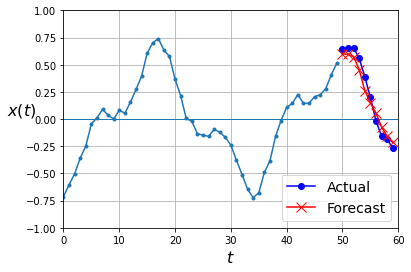

In [13]:
np.random.seed(43)


series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.title("Using  LSTM")
plt.show()


## Gated Recurrent Unit GRU

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=8,
                    validation_data=(X_valid, Y_valid))


Epoch 1/8
219/219 [==============================] - 18s 48ms/step - loss: 0.0751 - last_time_step_mse: 0.0664 - val_loss: 0.0548 - val_last_time_step_mse: 0.0443
Epoch 2/8
219/219 [==============================] - 9s 40ms/step - loss: 0.0491 - last_time_step_mse: 0.0388 - val_loss: 0.0453 - val_last_time_step_mse: 0.0347
Epoch 3/8
219/219 [==============================] - 9s 39ms/step - loss: 0.0437 - last_time_step_mse: 0.0330 - val_loss: 0.0422 - val_last_time_step_mse: 0.0315
Epoch 4/8
219/219 [==============================] - 9s 39ms/step - loss: 0.0406 - last_time_step_mse: 0.0296 - val_loss: 0.0388 - val_last_time_step_mse: 0.0284
Epoch 5/8
219/219 [==============================] - 9s 39ms/step - loss: 0.0375 - last_time_step_mse: 0.0267 - val_loss: 0.0360 - val_last_time_step_mse: 0.0248
Epoch 6/8
219/219 [==============================] - 9s 41ms/step - loss: 0.0345 - last_time_step_mse: 0.0233 - val_loss: 0.0328 - val_last_time_step_mse: 0.0193
Epoch 7/8
219/219 [========

1/1 [==============================] - 0s 36ms/step


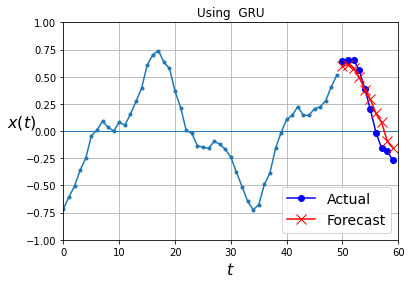

In [18]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.title("Using  GRU")
plt.show()


## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

Es decir que en este caso, debemos recortar los primeros tres pasos de tiempo en los
**target** (dado que el tamaño del kernel es 4, la primera salida de la capa
convolucional se basará en los pasos de tiempo de entrada de 0 a 3), y reducir la
cantidad de sequencias de salida en un factor 2 lo que se logra :
```python
Target[:, 3::2]
```

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=8,
                    validation_data=(X_valid, Y_valid[:, 3::2]))


Epoch 1/8
219/219 [==============================] - 13s 28ms/step - loss: 0.0686 - last_time_step_mse: 0.0600 - val_loss: 0.0447 - val_last_time_step_mse: 0.0359
Epoch 2/8
219/219 [==============================] - 5s 21ms/step - loss: 0.0381 - last_time_step_mse: 0.0299 - val_loss: 0.0334 - val_last_time_step_mse: 0.0242
Epoch 3/8
219/219 [==============================] - 5s 21ms/step - loss: 0.0311 - last_time_step_mse: 0.0219 - val_loss: 0.0292 - val_last_time_step_mse: 0.0192
Epoch 4/8
219/219 [==============================] - 5s 23ms/step - loss: 0.0274 - last_time_step_mse: 0.0172 - val_loss: 0.0260 - val_last_time_step_mse: 0.0156
Epoch 5/8
219/219 [==============================] - 5s 22ms/step - loss: 0.0253 - last_time_step_mse: 0.0146 - val_loss: 0.0246 - val_last_time_step_mse: 0.0138
Epoch 6/8
219/219 [==============================] - 5s 23ms/step - loss: 0.0239 - last_time_step_mse: 0.0128 - val_loss: 0.0231 - val_last_time_step_mse: 0.0117
Epoch 7/8
219/219 [========

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()

# una capa de entrada explícita (esto es más simple q de establecer input_shape en la 1ra capa)
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

# agregar pares de capas similares usando tasas de dilatación
# crecientes: 1, 2, 4, 8 y nuevamente 1, 2, 4, 8.
for rate in (1, 2, 4, 8) * 2:  # el *2 es para apilar dos tipos de capas

    # padding= "causal": equivalente a rellenar las entradas con la cantidad
    # correcta de ceros a la izquierda y usar relleno "valid"

    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))

# Finalmente, agregamos la capa de salida: una capa convolucional con 10 filtros de tamaño 1
# y sin función de activación
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=8,
                    validation_data=(X_valid, Y_valid))


Epoch 1/8
219/219 [==============================] - 10s 30ms/step - loss: 0.0621 - last_time_step_mse: 0.0492 - val_loss: 0.0360 - val_last_time_step_mse: 0.0217
Epoch 2/8
219/219 [==============================] - 5s 22ms/step - loss: 0.0331 - last_time_step_mse: 0.0201 - val_loss: 0.0305 - val_last_time_step_mse: 0.0175
Epoch 3/8
219/219 [==============================] - 4s 19ms/step - loss: 0.0293 - last_time_step_mse: 0.0170 - val_loss: 0.0281 - val_last_time_step_mse: 0.0157
Epoch 4/8
219/219 [==============================] - 4s 20ms/step - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0262 - val_last_time_step_mse: 0.0143
Epoch 5/8
219/219 [==============================] - 5s 22ms/step - loss: 0.0254 - last_time_step_mse: 0.0136 - val_loss: 0.0249 - val_last_time_step_mse: 0.0132
Epoch 6/8
219/219 [==============================] - 4s 20ms/step - loss: 0.0243 - last_time_step_mse: 0.0125 - val_loss: 0.0236 - val_last_time_step_mse: 0.0117
Epoch 7/8
219/219 [========

Here is the original WaveNet defined in the paper: it uses` Gated Activation Units` instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

**Gated Activation Units (GAUs)** es una técnica de aprendizaje profundo que se utiliza para mejorar la representación de las características en las redes neuronales. En GAUs, la entrada se divide en dos partes: una parte que se procesa directamente a través de una función de activación, y una parte que se procesa a través de una compuerta. La compuerta se utiliza para controlar la influencia de la entrada en la activación de la neurona, permitiendo que la red pueda enfocarse en características específicas de la entrada.

In [29]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate


In [27]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z


In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 10  # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])


In [31]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))


Epoch 1/2
219/219 [==============================] - 9s 31ms/step - loss: 0.1288 - last_time_step_mse: 0.1247 - val_loss: 0.1225 - val_last_time_step_mse: 0.1195
Epoch 2/2
219/219 [==============================] - 5s 24ms/step - loss: 0.1220 - last_time_step_mse: 0.1176 - val_loss: 0.1216 - val_last_time_step_mse: 0.1188
